- load model #16
- explainer = shap.KernelExplainer(model, X_train)
- get shap_values = explainer.shap_values(X_test_shap)
- save shap_values_16_n_samples.npy\
=> shap values for 212 features! 128 svd components + 84 handselected genes
- same steps for model #17

In [1]:
%%capture output
!pip install --upgrade pip
!pip install --upgrade pandas
!pip install tables
# necessary for pd.read_hdf()
!pip install shap

!pip install ipywidgets
!pip install --upgrade jupyter
!pip install IProgress
# !pip install catboost
!pip install shap
!pip install anndata

In [2]:
import os
import numpy as np
import pandas as pd
import pickle

import shap

import anndata as ad

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)

## data load

In [4]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/open-problems-multimodal-3rd-solution/'
private_data_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data'

raw_path =  lrz_path + 'input/raw/'  # '../../../input/raw/'

cite_target_path = lrz_path + 'input/target/cite/'   # '../../../input/target/cite/'
cite_feature_path = lrz_path + 'input/features/cite/'   # '../../../input/features/cite/'
cite_mlp_path = lrz_path + 'model/cite/mlp/'   # '../../../model/cite/mlp/'   # '../../../model/cite/mlp/'
cite_cb_path = lrz_path + 'model/cite/cb/'   # '../../../model/cite/cb/'

# multi_target_path = lrz_path + 'input/target/multi/'   # '../../../input/target/multi/'
# multi_feature_path = lrz_path + 'input/features/multi/'   # '../../../input/features/multi/'
# multi_mlp_path = lrz_path + 'model/multi/mlp/'   # '../../../model/multi/mlp/'
# multi_cb_path = lrz_path + 'model/multi/cb/'   # '../../../model/multi/cb/'

index_path = lrz_path + 'input/preprocess/cite/'

output_path = lrz_path + 'output/'   # '../../../output/'

## Cite  (code from codebase, same steps as in run_model.ipynb)

In [5]:
# short names of models used in ensemble
mlp_model_name = [
    'corr_add_con_imp',
    'corr_last_v3', 
    'corr_c_add_w2v_v1_mish_flg',
    'corr_c_add_w2v_v1_flg',
    'corr_c_add_84_v1',
    'corr_c_add_120_v1',
    'corr_w2v_cell_flg',
    'corr_best_cell_120',
    'corr_cluster_cell',
    'corr_w2v_128',
    'corr_imp_w2v_128',
    'corr_snorm',
    'corr_best_128',
    'corr_best_64',
    'corr_cluster_128',
    'corr_cluster_64',
    'corr_svd_128',
    'corr_svd_64',
             ]

In [6]:
# create model_name_list containing the actual file name of each model from mlp_model_name
model_name_list = []

for i in mlp_model_name:
    for num, j in enumerate(os.listdir(cite_mlp_path)):
        if i in j:
            model_name_list.append(j)

len(model_name_list)
model_name_list

['cite_mlp_corr_add_con_imp_flg_donor_val_50',
 'cite_mlp_corr_last_v3_flg_donor_val_55',
 'cite_mlp_corr_c_add_w2v_v1_mish_flg_donor_val_66',
 'cite_mlp_corr_c_add_w2v_v1_flg_donor_val_66',
 'cite_mlp_corr_c_add_84_v1_flg_donor_val_47',
 'cite_mlp_corr_c_add_120_v1_flg_donor_val_63',
 'cite_mlp_corr_w2v_cell_flg_donor_val_51',
 'cite_mlp_corr_best_cell_120_flg_donor_val_51',
 'cite_mlp_corr_cluster_cell_flg_donor_val_64',
 'cite_mlp_corr_w2v_128_flg_donor_val_42',
 'cite_mlp_corr_imp_w2v_128_flg_donor_val_38',
 'cite_mlp_corr_snorm_flg_donor_val_39',
 'cite_mlp_corr_best_128_flg_donor_val_45',
 'cite_mlp_corr_best_64_flg_donor_val_50',
 'cite_mlp_corr_cluster_128_flg_donor_val_51',
 'cite_mlp_corr_cluster_64_flg_donor_val_57',
 'cite_mlp_corr_svd_128_flg_donor_val_30',
 'cite_mlp_corr_svd_64_flg_donor_val_38']

In [7]:
# list of file names: test sets that correspond to each model in model_name_list
# weights used for weighting model predictions in ensemble
weight = [1, 0.3, 1, 1, 1, 1, 1, 1, 1, 0.8, 0.8, 0.8, 0.8, 0.5, 0.5, 0.5, 1, 1, 2, 2]
weight_sum = np.array(weight).sum()
weight_sum

# create dict of shape {model_name: [test set, weight]}
model_feat_dict = {model_name_list[0]:['X_test_add_con_imp.pickle', 1],
                   model_name_list[1]:['X_test_last_v3.pickle', 0.3],
                   model_name_list[2]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[3]:['X_test_c_add_w2v_v1.pickle', 1],
                   model_name_list[4]:['X_test_c_add_84_v1.pickle', 1],
                   model_name_list[5]:['X_test_c_add_v1.pickle', 1],
                   
                   model_name_list[6]:['X_test_feature_w2v_cell.pickle', 1],
                   model_name_list[7]:['X_test_best_cell_128_120.pickle', 1],
                   model_name_list[8]:['X_test_cluster_cell_128.pickle', 1],
                   
                   model_name_list[9]:['X_test_feature_w2v.pickle', 0.8],
                   model_name_list[10]:['X_test_feature_imp_w2v.pickle',0.8],
                   model_name_list[11]:['X_test_feature_snorm.pickle', 0.8],
                   model_name_list[12]:['X_test_best_128.pickle', 0.8],
                   model_name_list[13]:['X_test_best_64.pickle', 0.5],
                   model_name_list[14]:['X_test_cluster_128.pickle', 0.5],
                   model_name_list[15]:['X_test_cluster_64.pickle', 0.5],
                   model_name_list[16]:['X_test_svd_128.pickle', 1],
                   model_name_list[17]:['X_test_svd_64.pickle', 1],
                   
                   'best_128':['X_test_best_128.pickle', 2],
                   'best_64':['X_test_best_64.pickle', 2],
                  }

### cite model (from codebase)

Only need to load the model, not run the predictions as they are in run_model.ipynb

In [8]:
def std(x):
    x = np.array(x)
    return (x - x.mean(1).reshape(-1, 1)) / x.std(1).reshape(-1, 1)

In [9]:
class CiteDataset_test(Dataset):
    
    def __init__(self, feature):
        self.feature = feature
        
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, index):
                
        d = {
            "X": self.feature[index]
        }
        return d

In [ ]:
class CiteModel(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.ReLU(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.ReLU(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.ReLU(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
        
        from_numpy = False
        
      ##
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X)
            from_numpy = True
        X = X.to(device)  # Move the input to the appropriate device if necessary
        ##
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        if from_numpy:
            out = out.cpu().detach().numpy()
            
        return out

In [ ]:
class CiteModel_mish(nn.Module):
    
    def __init__(self, feature_num):
        super(CiteModel_mish, self).__init__()
        
        self.layer_seq_256 = nn.Sequential(nn.Linear(feature_num, 256),
                                           nn.Linear(256, 128),
                                       nn.LayerNorm(128),
                                       nn.Mish(),
                                      )
        self.layer_seq_64 = nn.Sequential(nn.Linear(128, 64),
                                       nn.Linear(64, 32),
                                       nn.LayerNorm(32),
                                       nn.Mish(),
                                      )
        self.layer_seq_8 = nn.Sequential(nn.Linear(32, 16),
                                         nn.Linear(16, 8),
                                       nn.LayerNorm(8),
                                       nn.Mish(),
                                      )
        
        self.head = nn.Linear(128 + 32 + 8, 140)
                   
    def forward(self, X, y=None):
    
        X_256 = self.layer_seq_256(X)
        X_64 = self.layer_seq_64(X_256)
        X_8 = self.layer_seq_8(X_64)
        
        X = torch.cat([X_256, X_64, X_8], axis = 1)
        out = self.head(X)
        
        return out

In [ ]:
def test_loop(model, loader):
    
    model.eval()
    predicts=[]

    for d in tqdm(loader):
        with torch.no_grad():
            X = d['X'].to(device)
            logits = model(X)
            predicts.append(logits.detach().cpu().numpy())
            
    return np.concatenate(predicts)

### model #16

In [ ]:
# only need model, not whole prediction

# model #16: cite_mlp_corr_svd_128_flg_donor_val_30

model_name = 'cite_mlp_corr_svd_128_flg_donor_val_30'
        
test_file = model_feat_dict[model_name][0]
X_test = pd.read_pickle(cite_feature_path  + test_file)
X_test = np.array(X_test)
feature_dims = X_test.shape[1]

if 'mish' in i:
    model16 = CiteModel_mish(feature_dims)
else:
    model16 = CiteModel(feature_dims)
    
model16 = model16.to(device)
model16.load_state_dict(torch.load(f'{cite_mlp_path}/{model_name}'))

### prepare data to get shap values used for plots in plotting.ipynb 
### => shap.KernelExplainer, explainer.shap_values

In [ ]:
# X_train for model #16: 'X_svd_128.pickle'
X_train = pd.read_pickle(cite_feature_path  + 'X_svd_128.pickle')
# X_train = np.array(X_train)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

# explainer16 = shap.KernelExplainer(model16, shap.sample(X_train, 1000))

med = X_train.median().values.reshape((1,X_train.shape[1]))
# explainer16 = shap.KernelExplainer(model16, med)

# zeros = np.zeros((1,212), dtype=float)
explainer16 = shap.KernelExplainer(model16, med)

In [ ]:
X_test_shap = ad.read_h5ad('X_test_shap_16_50_samples.h5ad')

In [ ]:
np.set_printoptions(suppress=True)
med[:,:15].round(2)

In [ ]:
# features: genes and svd -> omnipath: genes
# model: mostly relying on genes or svd? -> later

In [ ]:
# # don't need to run again: np.load('shap_values.npy', allow_pickle=True)
# %timeit
# shap_values = explainer16.shap_values(X_test_shap.to_df(), nsamples=300)  #500? 
# print(len(shap_values)) # -> 140 genes
# print(len(shap_values[0])) # -> number of samples in xtest
# print(shap_values[0].shape)

# TODO rename files once double checked that everything works after restructuring
# np.save('shap_values_16_50_samples_med.npy', np.array(shap_values, dtype=object), allow_pickle=True)

In [ ]:
# shap_values[0]

### model #17

In [ ]:
# only need model, not whole prediction
# model #17: cite_mlp_corr_svd_64_flg_donor_val_38

model_name = 'cite_mlp_corr_svd_64_flg_donor_val_38'
        
test_file = model_feat_dict[model_name][0]
X_test = pd.read_pickle(cite_feature_path  + test_file)
X_test = np.array(X_test)
feature_dims = X_test.shape[1]

if 'mish' in i:
    model17 = CiteModel_mish(feature_dims)
else:
    model17 = CiteModel(feature_dims)
    
model17 = model17.to(device)
model17.load_state_dict(torch.load(f'{cite_mlp_path}/{model_name}'))

### prepare data to get shap values used for plots in plotting.ipynb 
### => shap.KernelExplainer, explainer.shap_values

In [ ]:
# X_train for model #17: 'X_svd_64.pickle'
X_train = pd.read_pickle(cite_feature_path  + 'X_svd_64.pickle')
# X_train = np.array(X_train)
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer17 = shap.KernelExplainer(model17, med)  #shap.sample(X_train, 1000))

In [ ]:
X_test_shap = ad.read_h5ad('X_test_shap_17_50_samples.h5ad')

In [ ]:
# # don't need to run again: np.load('shap_values.npy', allow_pickle=True)
# %timeit
# shap_values = explainer17.shap_values(X_test_shap.to_df(), nsamples=300)  #500? 
# print(len(shap_values)) # -> 140 genes
# print(len(shap_values[0])) # -> number of samples in xtest
# print(shap_values[0].shape)

# TODO rename files once double checked that everything works after restructuring
# np.save('shap_values_17_50_samples_med.npy', np.array(shap_values, dtype=object), allow_pickle=True)

In [ ]:
# shap_values[0]

### same steps for private test data

steps for model 16: compute shap values on 50 samples per cell type

In [ ]:
X_train_p_sampled = ad.read_h5ad('private_train_input_max_samples.h5ad')  # 160 samples per cell type -> even distr.
X_train_p_sampled.obs

In [ ]:
X_train_p_16 = pd.read_pickle('private_X_train_svd_128.pkl')            # use full train set
X_train_p_16 = X_train_p_16.iloc[np.sort(X_train_p_sampled.obs['ID'])]     # use 160 samples per cell type -> even distr.

X_test_p_16 = ad.read_h5ad('private_test_input_128_svd_50_samples.h5ad')

print('X_train: ', X_train_p_16.shape)
print('X_test: ', X_test_p_16.shape)

med = X_train_p_16.median().values.reshape((1,X_train_p_16.shape[1]))
explainer16_p = shap.KernelExplainer(model16, med.astype('float32'))

# shap_values_16_p = explainer16_p.shap_values(X_test_p_16.to_df(), nsamples=300)

In [ ]:
# np.save('shap_values_16_50_samples_p_ct_distr.npy', np.array(shap_values_16_p, dtype=object), allow_pickle=True)

#### analyse SHAP properties on 5 samples per cell type

use data with svd components and handselected genes but only use handselected genes for comparison between models 16, 17, and ensemble.

In [ ]:
X_test_p_16 = ad.read_h5ad('private_test_input_128_svd_5_samples.h5ad')
X_test_p_16.to_df().median().values.reshape((1,X_train_p_16.shape[1]))[:,-84:]  # X_test column median of the handselected genes

In [ ]:
# shap_values_16_p_5 = explainer16_p.shap_values(X_test_p_16.to_df(), nsamples=300)

In [ ]:
# np.save('shap_values_16_p_5_properties.npy', np.array(shap_values_16_p_5, dtype=object), allow_pickle=True)

In [ ]:
shap_values_16_p_5 = np.load('shap_values_16_p_5_properties.npy', allow_pickle=True)

In [ ]:
pd.DataFrame(shap_values_16_p_5[0])

#### dummy
gene with no information (i.e. X_train median) should get shap value 0
-> works

In [ ]:
# median of X_train (same median used for training explainer) of last column
X_test_p_dummy = X_test_p_16.to_df().copy()
last_column_median = med[:,-1]
# Replace the last column with the median value for all rows
X_test_p_dummy.iloc[:, -1] = last_column_median
# shap_values_16_p_5_dummy = explainer16_p.shap_values(X_test_p_dummy, nsamples=300)
# np.save('shap_values_16_p_5_properties_set_median_train.npy', np.array(shap_values_16_p_5_dummy, dtype=object), allow_pickle=True)
shap_values_16_p_5_dummy = np.load('shap_values_16_p_5_properties_set_median_train.npy', allow_pickle=True)
pd.DataFrame(shap_values_16_p_5_dummy[0])

#### efficiency
SHAP values add up to the difference between the expected model output and the actual output for a given input cell.

In [ ]:
# works for all proteins and all cells: difference is very small (e-07 -> approx)
protein_idx = 104
cell_idx = 30
shap_v = shap_values_16_p_5[protein_idx][cell_idx].sum()    # [protein][cell]
shap_v

In [ ]:
test_ds = CiteDataset_test(X_test_p_16.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred = test_loop(model16, test_dataloader).astype(np.float32)

predicted = pd.DataFrame(pred).iloc[cell_idx][protein_idx]    # [cell][protein]
predicted

In [ ]:
expected = explainer16_p.expected_value[protein_idx]   # first protein
print(expected)
print(expected - (predicted - shap_v))
np.abs(expected - (predicted - shap_v)) <= 0.0001

In [ ]:
explainer16_p.expected_value.shape

#### consistency
higher feature value => non-decreasing shap value

In [91]:
# consistency:
X_test_plus_one = X_test_p_16.to_df().copy()
X_test_plus_one['imp_83'] = X_test_plus_one['imp_83'] + 5   # +5 guarantees all values are above median
X_test_plus_one
shap_values_16_p_5_plus_one = explainer16_p.shap_values(X_test_plus_one, nsamples=300)

  0%|          | 0/35 [00:00<?, ?it/s]

In [90]:
# medians of last five handselected genes before and after +5
print(X_test_p_16.to_df().median().values.reshape((1,X_test_p_16.to_df().shape[1]))[:,-5:])
print(X_test_plus_one.median().values.reshape((1,X_test_plus_one.shape[1]))[:,-5:])


[[0.        1.8109733 2.214576  2.232008  1.9924533]]
[[0.        1.8109733 2.214576  2.232008  6.9924536]]


In [92]:
np.save('shap_values_16_p_5_plus_one.npy', np.array(shap_values_16_p_5_plus_one, dtype=object), allow_pickle=True)
shap_values_16_p_5_plus_one = np.load('shap_values_16_p_5_plus_one.npy', allow_pickle=True)

In [100]:
pd.DataFrame(shap_values_16_p_5_plus_one[0])[211]

0    -0.001897
1     0.022865
2     0.016682
3     0.025598
4          0.0
5     0.034041
6          0.0
7     0.011268
8     0.012436
9     0.019273
10    0.008837
11     0.02111
12    0.040021
13    0.017054
14    0.022155
15    0.013309
16    0.027729
17    0.015661
18     0.01748
19     0.01814
20    0.003208
21    0.003381
22    0.004783
23    0.013172
24    0.020969
25         0.0
26         0.0
27         0.0
28         0.0
29         0.0
30     0.01744
31    0.025266
32         0.0
33    0.010643
34    0.024496
Name: 211, dtype: object

In [99]:
pd.DataFrame(shap_values_16_p_5[0])[211]

0          0.0
1          0.0
2     0.004423
3     0.000356
4     0.023206
5          0.0
6    -0.000494
7          0.0
8          0.0
9          0.0
10         0.0
11         0.0
12         0.0
13         0.0
14         0.0
15   -0.009676
16         0.0
17         0.0
18         0.0
19         0.0
20         0.0
21         0.0
22         0.0
23         0.0
24         0.0
25         0.0
26         0.0
27         0.0
28    0.009655
29         0.0
30         0.0
31    0.014095
32         0.0
33         0.0
34         0.0
Name: 211, dtype: object

In [97]:
pd.DataFrame(shap_values_16_p_5[0])[211] <= pd.DataFrame(shap_values_16_p_5_plus_one[0])[211]

0     False
1      True
2      True
3      True
4     False
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28    False
29     True
30     True
31     True
32     True
33     True
34     True
Name: 211, dtype: bool

### waterfall

In [42]:
# explainer_w = shap.KernelExplainer(model16, med)
# shap_vals = explainer_w(X_test_p.to_df())


In [43]:
# with open("explanation.pkl", "wb") as file:
#     pickle.dump(shap_vals, file)

In [44]:
# np.save('shap_vals_waterfall_data.npy', np.array(shap_vals.data, dtype=object), allow_pickle=True)

In [45]:
with open("explanation.pkl", "rb") as file:
    shap_vals_waterfall = pickle.load(file)

In [46]:
shap_vals_waterfall

.values =
array([[[ 0.01280924,  0.00212279, -0.00654638, ...,  0.06154885,
         -0.02373945, -0.03577214],
        [ 0.34539623,  0.0019652 , -0.00801785, ...,  0.02783672,
         -0.2311595 ,  0.1881909 ],
        [-0.09275184, -0.01197663, -0.02124413, ...,  0.00385958,
         -0.07569602, -0.05543572],
        ...,
        [-0.00300983,  0.00187449,  0.00073629, ..., -0.0040005 ,
          0.00423564,  0.00187698],
        [ 0.00354698,  0.        , -0.00120936, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00877515,  0.00593409, ..., -0.00161831,
          0.00946353,  0.00854636]],

       [[ 0.        , -0.00079469, -0.00041693, ..., -0.00320571,
          0.00126306,  0.00271876],
        [-0.0263311 ,  0.00308652,  0.00272771, ..., -0.01088741,
          0.03089869, -0.01214099],
        [ 0.02785237,  0.0190467 ,  0.01469856, ..., -0.05500721,
          0.04274619,  0.03669711],
        ...,
        [-0.00050465, -0.00044305, -0.000940

IndexError: invalid index to scalar variable.

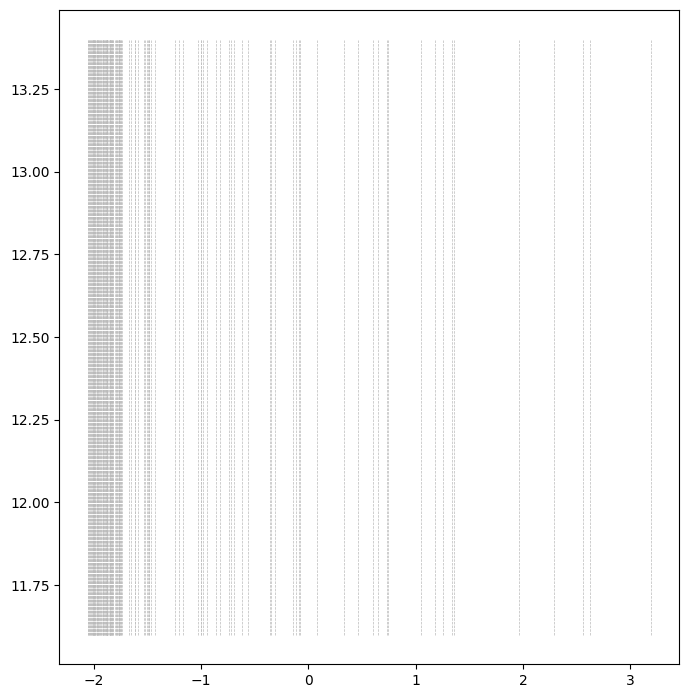

In [73]:
shap.plots.waterfall(shap_vals_waterfall[0][0], max_display=14)

In [ ]:
shap.plots.waterfall(shap_values_16_p_5, max_display=14)

### steps for model 17: compute shap values on 50 samples per cell type

In [48]:
X_train_p_17 = pd.read_pickle('private_X_train_svd_64.pkl')
X_train_p_17 = X_train_p_17.iloc[np.sort(X_train_p_sampled.obs['ID'])]      # use 160 samples per cell type -> even distr.

X_test_p_17 = ad.read_h5ad('private_test_input_64_svd_5_samples.h5ad')

print('X_train: ', X_train_p_17.shape)
print('X_test: ', X_test_p_17.shape)

med = X_train_p_17.median().values.reshape((1,X_train_p_17.shape[1]))
explainer17_p = shap.KernelExplainer(model17, med)

# shap_values_17_p = explainer17_p.shap_values(X_test_p_17.to_df(), nsamples=300)

X_train:  (1120, 148)
X_test:  (35, 148)


In [ ]:
# np.save('shap_values_17_50_samples_p_ct_distr.npy', np.array(shap_values_17_p, dtype=object), allow_pickle=True)
# np.save('shap_values_17_p_5_properties.npy', np.array(shap_values_17_p, dtype=object), allow_pickle=True)

In [49]:
shap_values_17_p_5 = np.load('shap_values_17_p_5_properties.npy', allow_pickle=True)

#### check SHAP properties:

#### dummy

In [50]:
# median of X_train (same median used for training explainer) of last column
X_test_p_dummy = X_test_p_17.to_df().copy()
last_column_median = med[:,-1]
# Replace the last column with the median value for all rows
X_test_p_dummy.iloc[:, -1] = last_column_median
# shap_values_17_p_5_dummy = explainer17_p.shap_values(X_test_p_dummy, nsamples=300)
# np.save('shap_values_17_p_5_properties_set_median_train.npy', np.array(shap_values_17_p_5_dummy, dtype=object), allow_pickle=True)
shap_values_17_p_5_dummy = np.load('shap_values_17_p_5_properties_set_median_train.npy', allow_pickle=True)
pd.DataFrame(shap_values_17_p_5_dummy[127])

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,0.0,0.129769,-0.135797,-0.009893,-0.015608,0.0,0.0,0.004761,0.0,-0.080656,...,0.010699,-0.011267,0.0,0.018032,0.0,0.014571,0.018159,0.0,0.0,0.0
1,0.0,-0.023373,0.045655,0.0,0.0,0.0,0.005992,-0.000805,-0.003113,0.009712,...,0.0,-0.008965,0.0,0.00376,-0.002778,0.01185,0.004316,0.0,0.005409,0.0
2,0.0,-0.026073,0.041756,-0.006252,-0.00525,-0.003133,0.00882,0.00159,0.010114,-0.029422,...,0.001059,0.0,0.0,0.000718,0.0,0.015844,0.001361,0.0,0.002751,0.0
3,0.001213,-0.01422,0.049424,0.0,0.00328,-0.008128,-0.0059,0.01083,-0.005464,0.0,...,0.000718,0.006119,-0.005634,0.0,0.0,0.013637,-0.033559,-0.001158,0.0,0.0
4,0.0,0.051701,-0.031154,0.0,-0.018027,-0.012227,0.006988,0.0,0.011156,-0.103664,...,0.0,-0.013045,0.0,-0.005444,0.0,0.0,0.007886,0.003621,0.0,0.0
5,0.0,-0.058556,0.027001,-0.014343,-0.004153,-0.006098,0.009811,0.0,-0.008827,0.022314,...,0.001289,-0.012941,-0.001828,-0.000748,0.0,0.013569,0.008123,-0.005922,0.0,0.0
6,0.008653,-0.029146,-0.007111,0.0,-0.155087,0.0,-0.028371,-0.004032,0.002055,0.009049,...,0.008945,0.000764,-0.004606,0.001183,0.0,0.01567,0.002777,0.0,0.0,0.0
7,-0.006853,-0.045218,-0.00161,-0.012904,-0.035781,0.029999,0.009923,0.0,0.0,0.012002,...,0.0,-0.008365,-0.016241,-0.000232,0.0,0.016486,0.005719,-0.002106,0.0,0.0
8,0.009298,0.003827,0.038391,0.0,-0.086368,0.0,0.003719,0.0,-0.003002,0.0,...,0.0,0.0,-0.010019,0.0,-0.007571,0.007782,0.0,0.0,0.010164,0.0
9,0.008561,-0.038519,0.006678,0.018035,-0.154255,0.0,0.016594,0.0,0.001284,0.015176,...,0.0,0.0,0.0,0.0,0.0,0.019757,0.002454,-0.010553,0.0,0.0


#### efficiency

In [51]:
# works for all proteins and all cells: difference is very small (e-07 -> approx)
protein_idx = 103
cell_idx = 30
shap_v = shap_values_17_p_5[protein_idx][cell_idx].sum()    # [protein][cell]
shap_v

-0.09376096725463867

In [52]:
# TODO something happened with X_test_p... wrong values
test_ds = CiteDataset_test(X_test_p_17.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred = test_loop(model17, test_dataloader).astype(np.float32)

predicted = pd.DataFrame(pred).iloc[cell_idx][protein_idx]    # [cell][protein]
predicted

  0%|          | 0/1 [00:00<?, ?it/s]

-1.1781821

In [53]:
expected = explainer17_p.expected_value[protein_idx]   # first protein
print(expected)
print(expected - (predicted - shap_v))
np.abs(expected - (predicted - shap_v)) <= 0.0001

-1.084421157836914
0.0


True

### ensemble analysis

Combine handselected genes of model 16 and 17 only. \
Weighted sum of the respective shap values. \
Check if these summed ensemble shap values fulfil the shap properties.

In [54]:
weights = [1, 0.3, 1, 1, 1, 1, 1, 1, 1, 0.8, 0.8, 0.8, 0.8, 0.5, 0.5, 0.5, 1, 1, 2, 2]   # ensemble weights from codebase
weight_sum = np.array(weights).sum()
# models 16 and 17 both have weight 1 -> normalize by weight_sum for this small ensemble of only 16 and 17
weight_16 = 1/2     # 1/2 since only 2? not 1 / weight_sum
weight_17 = 1/2     # 1 / weight_sum

In [55]:
shap_values_16_p_handselected = shap_values_16_p_5[:,:,-84:]

In [56]:
shap_values_17_p_handselected = shap_values_17_p_5[:,:,-84:]

In [57]:
shap_values_ensemble_p_handselected = weight_16 * shap_values_16_p_handselected + weight_17 * shap_values_17_p_handselected

#### dummy

fulfilled since weight_16 * 0 + weight_17 * 0 = 0

In [58]:
shap_values_ensemble_p_dummy = weight_16 * shap_values_16_p_5_dummy[:,:,-84:] + weight_17 * shap_values_17_p_5_dummy[:,:,-84:]
pd.DataFrame(shap_values_ensemble_p_dummy[0])

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.0,0.0,-0.009866,0.003867,0.0,0.0,0.0,-0.020003,-0.00411,0.0,...,0.0,-0.001905,0.0,-0.014983,0.0,0.0,0.005128,0.0,0.006797,0.0
1,0.0,0.016456,0.0,0.004125,-0.005761,0.0,0.0,-0.005401,0.0,0.0,...,-0.002335,-0.003458,0.0,0.00809,-0.004126,0.006342,-0.000882,0.002094,0.0,0.0
2,0.0,0.009443,0.0,0.008004,0.0,0.0,0.0,-0.003324,0.0,0.0,...,0.000676,0.0,0.0,0.0,0.0,0.000389,-0.002669,0.0,0.003384,0.0
3,0.0,0.011102,0.0,-0.0058,0.0,0.0,0.0,0.002907,-0.005022,0.0,...,0.005755,-0.003502,0.006486,-0.000388,0.0,0.010373,-0.012261,0.0,0.000336,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005923,0.0,-0.005989,...,0.0,-0.005323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.008081,-0.005963,-0.00148,0.011008,0.0,0.0,0.002118,-0.0136,0.0,...,-0.004801,-0.002554,0.001903,0.0,0.0,0.002376,-0.005475,-0.003651,0.0,0.0
6,0.0,0.008595,-0.003107,0.012017,0.0,0.00233,0.0,-0.005609,-0.010444,0.0,...,-0.000688,0.0,-0.000914,0.00807,0.0,0.01603,0.012673,0.000857,0.005796,0.0
7,0.0,0.010256,0.0,0.011372,-0.009051,0.0,0.0,0.0,0.0,0.0,...,0.003605,-0.010734,-0.005763,0.0,0.0,0.00294,0.0,-0.000243,0.005086,0.0
8,0.0,0.0,0.007953,0.001823,0.0,0.0,0.0,0.0,-0.000733,0.0,...,0.0,0.0,0.0,0.0,-0.010288,0.0,-0.004924,0.005853,-0.001903,0.0
9,-0.015726,-0.005611,-0.008036,0.0,0.0,-0.006556,0.0,0.0,-0.014953,0.0,...,-0.008205,-0.005264,0.0,0.0,0.0,0.015527,0.0,0.0,0.008925,0.0


#### efficiency

In [59]:
protein_idx = 0
cell_idx = 0
shap_v_16 = shap_values_16_p_5[protein_idx][cell_idx].sum()    # [protein][cell]
print(shap_v_16)
shap_v_17 = shap_values_17_p_5[protein_idx][cell_idx].sum()    # [protein][cell]
print(shap_v_17)

0.7560181468725204
0.542266845703125


In [60]:
shap_v_ensemble = shap_values_ensemble_p_handselected[protein_idx][cell_idx].sum()
shap_v_ensemble

-0.09168368628967088

In [61]:
test_ds = CiteDataset_test(X_test_p_16.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred16 = test_loop(model16, test_dataloader).astype(np.float32)

test_ds = CiteDataset_test(X_test_p_17.X)
test_dataloader = DataLoader(test_ds, batch_size=128, pin_memory=True, 
                            shuffle=False, drop_last=False, num_workers=4)
pred17 = test_loop(model17, test_dataloader).astype(np.float32)

pred = weight_16 * pred16 + weight_17 * pred17

predicted = pd.DataFrame(pred).iloc[cell_idx][protein_idx]    # [cell][protein]
predicted

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-0.3177299

In [101]:
expected = explainer16_p.expected_value[protein_idx]   # first protein
print(expected)
print(expected - (predicted - (weight_16 * shap_v_16 - weight_17 * shap_v_17)))
expected == predicted - (weight_16 * shap_v_16 + weight_17 * shap_v_17)

-0.843746542930603
-0.4191410019993782


False

In [103]:
predicted - shap_v_ensemble

-0.22604620405685621

#### consistency